# NLP Final COPA Project: RoBERTa

In [10]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim, cuda
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from datetime import datetime
import matplotlib.pyplot as plt
device = torch.device('cuda' if cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# there's a better way to do this wrt the question - it should just be a new token,
#   but I'm worried I'll break it if I try to change things at this point
def load_data(filename):
    with open(filename, 'r', encoding='utf8') as file:
        raw_data = pd.read_json(file, lines=True)
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    X = []
    y = []
    dataset = []
    
    for i, row in raw_data.iterrows(): # yeah, yeah, I know...
        prem = torch.tensor(tokenizer(row['premise'])['input_ids'])
        quest = torch.tensor(tokenizer(row['question'])['input_ids'])
        h1 = torch.tensor(tokenizer(row['choice1'])['input_ids'])
        h2 = torch.tensor(tokenizer(row['choice2'])['input_ids'])
#         X.append((torch.cat((prem, h1, h2))))
#         y.append(torch.tensor(row['label']).to(torch.float32))
        dataset.append((torch.cat((prem, quest, h1, h2)).to(device), torch.tensor(row['label']).to(torch.float32).to(device)))
    
#     dataset = (torch.tensor(X).to(device), torch.tensor(Y).to(device))
    return dataset

In [3]:
train_data = load_data('data/train.jsonl')
print(f'Training data loaded (length {len(train_data)})')
dev_data = load_data('data/dev.jsonl')
print(f'Dev data loaded (length {len(dev_data)})')
test_data = load_data('data/test.jsonl')
print(f'Test data loaded (length {len(test_data)})')

Training data loaded (length 350)
Dev data loaded (length 50)
Test data loaded (length 100)


In [4]:
class COPAClassifier(nn.Module):
    def __init__(self, output_size=1):
        super().__init__()
        
        # default pretrained layer
        self.roberta = RobertaModel.from_pretrained('roberta-base')
#         self.roberta.requires_grad = False
        self.classifier = nn.Linear(768, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.classifier(self.roberta(input_ids=x)[1])
        
    def predict(self, x):
        return 1 if self.sigmoid(self.forward(x)) > 0.5 else 0

In [5]:
copa = COPAClassifier()
copa.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


COPAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [16]:
# 3) Now we train our model. 
start_time = datetime.now()
epochs = 350
report_per = 50
bce = nn.BCELoss()
sigmoid = nn.Sigmoid()
optimizer = optim.Adam(copa.parameters(), lr=0.2)

dev_acc = np.zeros(epochs // report_per)
loss_by_epoch = np.zeros(epochs)

for i in range(epochs):
    if i % report_per == 0:
        print('### Epoch: ' + str(i+1) + ' ###')
    av_loss = 0
    copa.train()
    for (x, y) in train_data:
        optimizer.zero_grad()
        
        # a) calculate probs / get an output
        out = copa(x.unsqueeze(0))
        y_hat = sigmoid(out.squeeze(0).squeeze(0))
        
        # b) compute loss
        loss = bce(y_hat, y)
        av_loss += loss
        
        # c) get the gradient
        loss.backward()

        # d) update the weights
        optimizer.step()
        
    loss_by_epoch[i] = av_loss/len(train_data)
    
    # validate
    copa.eval()
    if i + 1 % report_per == 0:
        for (x, y) in dev_data:
            y_hat = copa.predict(x.unsqueeze(0))
            if y_hat == y:
                dev_acc[i // report_per] += 1
        dev_acc[i // report_per] /= len(dev_data)

end_time = datetime.now()
print(f'Training completed in {str(end_time - start_time)}')

### Epoch: 1 ###
### Epoch: 51 ###
### Epoch: 101 ###
### Epoch: 151 ###
### Epoch: 201 ###
### Epoch: 251 ###
### Epoch: 301 ###
Training completed in 5:32:25.704588


In [30]:
print(f'Previous training completed in {str(end_time - start_time)}')

Previous training completed in 0:00:53.831307


In [19]:
correct = 0
for (x, y) in dev_data:
    y_hat = copa.predict(x.unsqueeze(0))
    if y_hat == y:
        correct += 1

acc = correct / len(dev_data)
print(acc)

0.46


In [18]:
print(dev_acc)

[0. 0. 0. 0. 0. 0. 0.]


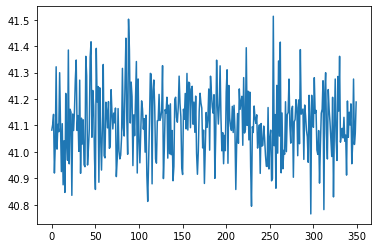

In [17]:
plot, ax = plt.subplots()
ax.plot(loss_by_epoch)
ax.plot()
plt.show()

## Notes
LSTM on top of BERT is probably a bad idea - overlaps; might be better to just use a fully connected linear layer  
Cause/effect token as extra input to the model